In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
import math
import matplotlib.pyplot as plt
import numpy as np

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import odl
import odlpet
from odl.contrib.torch import OperatorModule
from odl.contrib import fom

import time
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Unified configuration parameter management
# ---------------------------
config = {
    'image_size': 128,        # Image domain size 128x128
    'patch_size': 32,         # Patch size 32x32 (Thus, a total of (128/32)^2 = 16 patches)
    'num_angles': 128,        # Number of projection angles, determining the number of columns in the sinogram
    'num_detectors': 128,     # Number of detectors, determining the number of rows in the sinogram
    'src_radius': 500,        # Distance from the X-ray source to the center
    'det_radius': 500,        # Distance from the detector to the center
    'mu_water': 0.02          # Attenuation coefficient
}

# ---------------------------
# ODL setup based on parameters from config
# ---------------------------
size = config['image_size']
# The domain coordinate range is fixed at [-128,-128] to [128,128] (adjust according to actual needs)
space = odl.uniform_discr([-128, -128], [128, 128], [size, size],
                           dtype='float32', weighting=1.0)
angle_partition = odl.uniform_partition(0, 2 * np.pi, config['num_angles'])
detector_partition = odl.uniform_partition(-360, 360, config['num_detectors'])
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, 
                                     src_radius=config['src_radius'], 
                                     det_radius=config['det_radius'])
ray_transform = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(ray_transform)
operator = (1 / opnorm) * ray_transform
pseudoinverse = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.45)
mu_water = config['mu_water']

Starting get_indices with 16 patches ...
Processed patch 4/16 in 0.03 sec
Processed patch 8/16 in 0.03 sec
Processed patch 12/16 in 0.03 sec
Processed patch 16/16 in 0.03 sec
get_indices completed in 0.44 sec
stacked_tensor shape: torch.Size([16, 3896, 4])


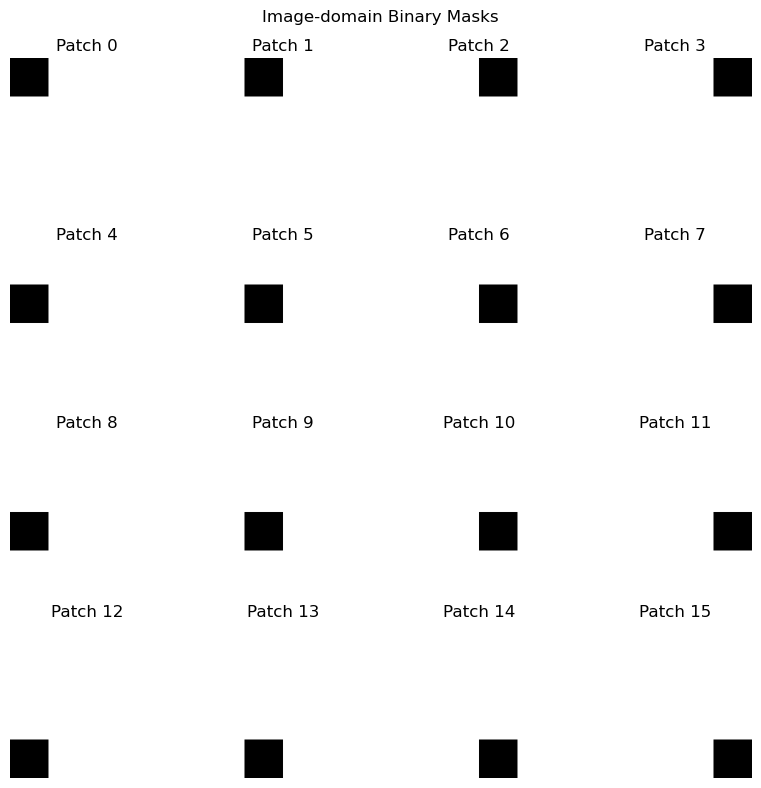

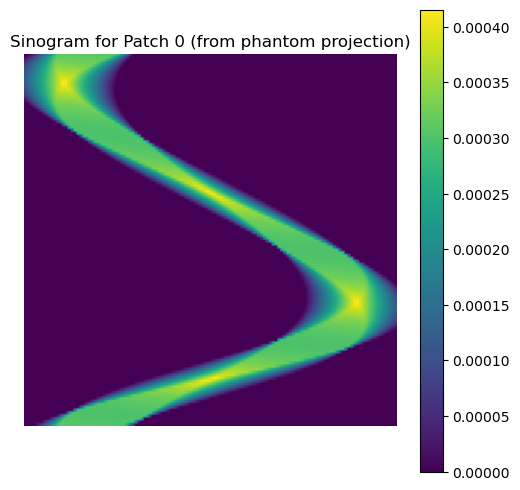

In [3]:
# ---------------------------
# get_indices function: Generate binary masks, sinogram projections, and indices
# ---------------------------
def get_indices(patch_size, s=0, dev='cuda'):
    """
    For an image-domain size of config['image_size'] x config['image_size'],
    patch_size: (height, width) e.g., (32,32)
    s: Threshold, set to 0
    
    Returns:
      stacked_tensor: Tensor [num_patches, max_length, 4], padded indices
      indices: list, each element is the original index tensor (N,4) for a patch (format [0,0,row,col])
      images: np.array, binary masks of each patch in the image domain, shape [num_patches, image_size, image_size]
      sinos: np.array, corresponding sinogram projections for each patch, shape [num_patches, num_detectors, num_angles]
    """
    image_shape = (config['image_size'], config['image_size'])
    if image_shape[0] % patch_size[0] != 0 or image_shape[1] % patch_size[1] != 0:
        raise ValueError("Image dimensions must be divisible by the patch size.")
    
    num_patches_grid = (image_shape[0] // patch_size[0], image_shape[1] // patch_size[1])
    num_patches = num_patches_grid[0] * num_patches_grid[1]
    
    images = np.zeros((num_patches, image_shape[0], image_shape[1]))
    # Sinogram size is determined by the number of detectors and angles
    sinos = np.zeros((num_patches, config['num_detectors'], config['num_angles']))
    indices = []
    
    print(f"Starting get_indices with {num_patches} patches ...")
    start_total = time.time()
    for k in range(num_patches):
        start_patch = time.time()
        i = k // num_patches_grid[1]
        j = k % num_patches_grid[1]
        # Set the current patch region to 1
        images[k, i*patch_size[0]:(i+1)*patch_size[0], j*patch_size[1]:(j+1)*patch_size[1]] = 1
        
        phantom = space.element(images[k])
        phantom /= 1000.0
        data = ray_transform(phantom)
        data = np.exp(-data * mu_water)
        log_data = np.log(data) * (-1 / mu_water) * (1 / opnorm)
        sinos[k] = log_data
        
        # Select pixel indices greater than threshold s (extract row, col), expand the first two dimensions to 0
        index = (torch.tensor(log_data) > s).nonzero()  # shape [N, 2]
        index = torch.cat([torch.zeros(index.shape[0], 2, dtype=torch.long), index], dim=1)
        indices.append(index)
        
        end_patch = time.time()
        if (k+1) % 4 == 0 or k == num_patches - 1:
            print(f"Processed patch {k+1}/{num_patches} in {end_patch - start_patch:.2f} sec")
    end_total = time.time()
    print(f"get_indices completed in {end_total - start_total:.2f} sec")
    
    lengths = [len(idx) for idx in indices]
    max_length = max(lengths)
    padded_tensors = []
    for idx in indices:
        pad_size = max_length - len(idx)
        padded_tensor = F.pad(idx, (0,0, pad_size,0))
        padded_tensors.append(padded_tensor)
    stacked_tensor = torch.stack(padded_tensors)
    print(f"stacked_tensor shape: {stacked_tensor.shape}")
    return stacked_tensor, indices, images, sinos

# Call get_indices (patch_size set to (32,32))
patch_size_tuple = (config['patch_size'], config['patch_size'])
stacked_indices, indices_list, images_mask, sinos_phantom = get_indices(patch_size_tuple, s=0, dev='cuda')

# Visualize all image-domain binary mask patches (16 in total)
num_patches = images_mask.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for idx in range(num_patches):
    ax = axes[idx//4, idx%4]
    ax.imshow(images_mask[idx], cmap='binary')
    ax.set_title(f"Patch {idx}")
    ax.axis('off')
plt.suptitle("Image-domain Binary Masks")
plt.tight_layout()
plt.show()

# Visualize the sinogram projection of the first patch (should show corresponding curved stripes)
plt.figure(figsize=(6,6))
plt.imshow(sinos_phantom[0], cmap='viridis')
plt.title("Sinogram for Patch 0 (from phantom projection)")
plt.colorbar()
plt.axis('off')
plt.show()

In [6]:
# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Residual Block for building deep neural networks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add shortcut connection
        out = self.relu(out)
        return out

In [7]:
class SelfAttentionBlock(nn.Module):
    """
    一个简单的自注意力层：
    - Q, K, V 全来自输入 x（即 sinogram tokens）
    - 后续加上残差连接、LayerNorm 和一个 MLP
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(SelfAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x: [B, num_patches, embed_dim]
        # 注意：这里只返回更新后的 x，不再返回 attn_weights，以便在 nn.Sequential 中正确传递
        attn_output, _ = self.mha(query=x, key=x, value=x)
        x = self.norm1(x + attn_output)
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x

# ---------------------------
# Model Definition: DualBranchTransformerModel
# ---------------------------
class DualBranchTransformerModel(nn.Module): 
    def __init__(self, indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(DualBranchTransformerModel, self).__init__()
        self.indices = indices  # [num_patches, patch_length, 4]
        self.num_patches = indices.shape[0]
        self.max_length = indices.shape[1]
        
        # Sinogram token embedding: 将每个 patch 提取的 token（长度为 max_length）映射到 embedding 空间
        self.sino_linear = nn.Linear(self.max_length, embed_dim)
        
        # Positional encodings (一份，每个 patch 一个编码)
        self.positional_encodings = nn.Parameter(torch.randn(self.num_patches * 1, embed_dim))
        
        # Global self-attention layers (采用多个 SelfAttentionBlock)
        layers = []
        for _ in range(num_layers):
            layers.append(SelfAttentionBlock(embed_dim, num_heads, dropout=dropout))
        self.self_attn = nn.Sequential(*layers)
        
        # Tail block: 将 embedding 映射回 token 原始长度
        # 这里使用更简单的 Rearrange，将形状 [B, num_patches, patch_length] 变为 [B, 1, num_patches, patch_length, 1]
        self.tail = nn.Sequential(
            nn.Linear(embed_dim, self.max_length),
            nn.ReLU(),
            Rearrange('b p v -> b 1 p v 1')
        )
        
        # Residual block for local enhancement
        self.residualBlock = nn.Sequential(
            Rearrange('b c h w s -> (b s) c h w'),
            ResidualBlock(in_channels=1, out_channels=1),
            Rearrange('(b s) c h w -> b c h w s', s=1)
        )
    
    def forward(self, sino):
        # sino: [B, 1, H, W]
        B = sino.shape[0]
        # --- Token extraction ---
        token_list = []
        for p in range(self.num_patches):
            idx = self.indices[p]  # [patch_length, 4]
            rows = idx[:, 2].to(sino.device)
            cols = idx[:, 3].to(sino.device)
            patch_tokens = []
            for b in range(B):
                patch_tokens.append(sino[b, 0, rows, cols])
            patch_tokens = torch.stack(patch_tokens, dim=0)  # [B, patch_length]
            token_list.append(patch_tokens)
        # tokens: [B, num_patches, patch_length]
        tokens = torch.stack(token_list, dim=1)
        
        # Linear mapping to embedding space
        H_enc = self.sino_linear(tokens)  # [B, num_patches, embed_dim]
        
        # Add positional encodings (repeat for batch)
        positional = self.positional_encodings.repeat(B, 1, 1)  # [B, num_patches, embed_dim]
        Z = H_enc + positional
        
        # Global self-attention layers
        Z = self.self_attn(Z)  # [B, num_patches, embed_dim]
        
        # Decode embeddings back to token length
        decoded_tokens = self.tail(Z)  # [B, 1, num_patches, patch_length, 1]
        decoded_tokens = decoded_tokens.squeeze(1).squeeze(-1)  # [B, num_patches, patch_length]
        
        # Write decoded tokens back into sinogram
        sino_out = sino.clone().squeeze(1)  # [B, H, W]
        for b in range(B):
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2].to(sino.device)
                cols = idx[:, 3].to(sino.device)
                sino_out[b, rows, cols] = decoded_tokens[b, p]
        
        # Apply residual block for local enhancement
        sino_out = self.residualBlock(sino_out.unsqueeze(1).unsqueeze(-1))  # [B, 1, H, W, 1]
        return sino_out.squeeze(-1)

sino_input shape: torch.Size([32, 1, 128, 128])
kernel_input shape: torch.Size([32, 1, 128, 128])
stacked_indices shape: torch.Size([16, 3896, 4])
Output sinogram shape: torch.Size([32, 1, 128, 128])


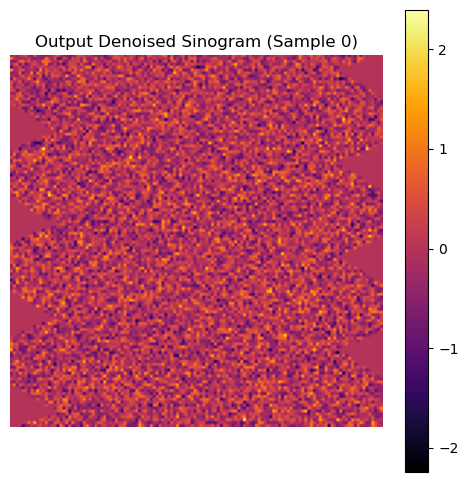

In [5]:
# ---------------------------
# Test Code: Testing with a saved dataset
# ---------------------------
# Load the saved dataset (all image sizes are 128x128)
dataset_dict = torch.load("pet_ct_dataset_test_odl.pt")
pet_sinograms_noised_cpu = dataset_dict['pet_sinograms_noised']  # List, each element has shape (128,128)
kernels_ct_cpu = dataset_dict['kernels_ct']                      # List, each element has shape (128,128)

# Convert list to tensor and add channel dimension: Final shape [N, 1, 128, 128]
sino_input = torch.stack([x for x in pet_sinograms_noised_cpu], dim=0).unsqueeze(1)
kernel_input = torch.stack([x for x in kernels_ct_cpu], dim=0).unsqueeze(1)
print("sino_input shape:", sino_input.shape)
print("kernel_input shape:", kernel_input.shape)

sino_input = sino_input.to(dev)
kernel_input = kernel_input.to(dev)

print("stacked_indices shape:", stacked_indices.shape)

# Create model instance
model = DualBranchTransformerModel(indices=stacked_indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1)
model = model.to(dev)

# Forward pass
sino_out = model(sino_input, kernel_input)
print("Output sinogram shape:", sino_out.shape)

# Visualize the output of the first sample
out_np = sino_out[0, 0].detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.imshow(out_np, cmap='inferno')
plt.title("Output Denoised Sinogram (Sample 0)")
plt.colorbar()
plt.axis('off')
plt.show()

In [8]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Custom Dataset for Training
# ---------------------------
class PETCTTrainDataset(Dataset):
    def __init__(self, dataset_dict):
        """
        dataset_dict: Contains the following keys:
            'pet_sinograms_noised': list of PET sinograms (each [128,128])
            'pet_sinograms_clean': list of clean PET sinograms (each [128,128])
        """
        self.pet_sinograms_noised = dataset_dict['pet_sinograms_noised']
        self.pet_sinograms_clean  = dataset_dict['pet_sinograms_clean']
        
    def __len__(self):
        return len(self.pet_sinograms_noised)
    
    def __getitem__(self, idx):
        # Add channel dimension: output shape becomes [1,128,128]
        sino_noised = self.pet_sinograms_noised[idx].unsqueeze(0)
        sino_clean  = self.pet_sinograms_clean[idx].unsqueeze(0)
        return sino_noised, sino_clean

In [9]:
# ---------------------------
# Define SSIM Loss and Mixed Loss Function
# ---------------------------
def gaussian(window_size, sigma):
    gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size(1)
    window = create_window(window_size, channel).to(img1.device)
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2
    
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2)) / ((mu1_sq+mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2))
    return ssim_map.mean() if size_average else ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
    def forward(self, img1, img2):
        return 1 - ssim(img1, img2, self.window_size, self.size_average)

mse_loss = nn.MSELoss()
ssim_loss_fn = SSIMLoss(window_size=11, size_average=True)

def mixed_loss(output, target, ssim_weight=0.5):
    loss_mse = mse_loss(output, target)
    loss_ssim = ssim_loss_fn(output, target)
    return loss_mse + ssim_weight * loss_ssim

In [10]:

# ---------------------------
# Training configuration
# ---------------------------
training_config = {
    'lr': 1e-4,               # Learning rate
    'num_epochs': 150,         # Number of training epochs
    'batch_size': 32,         # Batch size
    'ssim_weight': 0.5        # SSIM loss weight
}

# ---------------------------
# Create Dataset and DataLoader for sinogram-only training
# ---------------------------
dataset_dict = torch.load("pet_ct_dataset_odl.pt")
train_dataset = PETCTTrainDataset(dataset_dict)
train_loader = DataLoader(train_dataset, batch_size=training_config['batch_size'], shuffle=True)

# ---------------------------
# Create Model Instance and Move to Device
# ---------------------------
# 使用之前定义的 TransformerBlock
model = DualBranchTransformerModel(indices=stacked_indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ---------------------------
# Define Optimizer: Adam
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=training_config['lr'])


Epoch [1/150], Loss: 1149.8709
Epoch [2/150], Loss: 1079.7848
Epoch [3/150], Loss: 1013.9721
Epoch [4/150], Loss: 944.6958
Epoch [5/150], Loss: 879.9797
Epoch [6/150], Loss: 816.9815
Epoch [7/150], Loss: 759.1003
Epoch [8/150], Loss: 706.1794
Epoch [9/150], Loss: 656.8649
Epoch [10/150], Loss: 613.2433


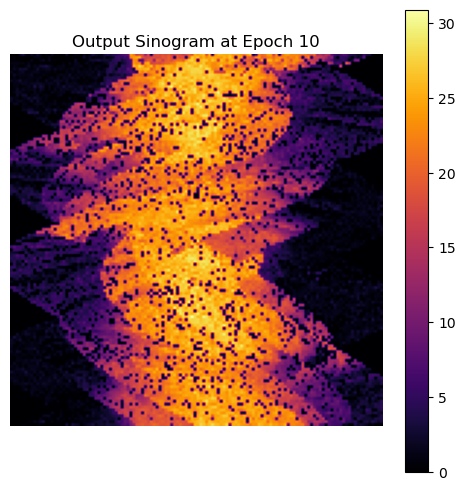

Epoch [11/150], Loss: 571.3287
Epoch [12/150], Loss: 532.9157
Epoch [13/150], Loss: 498.3750
Epoch [14/150], Loss: 464.7262
Epoch [15/150], Loss: 433.9121
Epoch [16/150], Loss: 406.8760
Epoch [17/150], Loss: 381.2591
Epoch [18/150], Loss: 357.5051
Epoch [19/150], Loss: 335.3186
Epoch [20/150], Loss: 315.0437


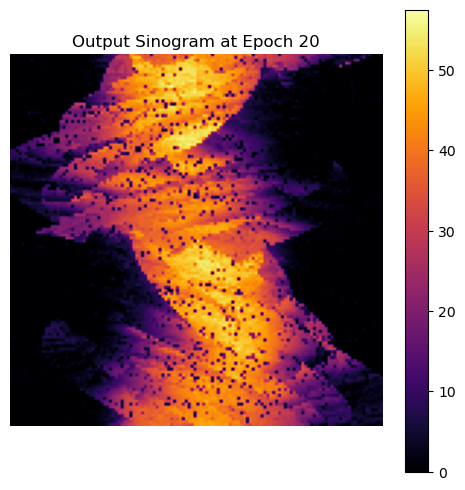

Epoch [21/150], Loss: 292.7834
Epoch [22/150], Loss: 273.3818
Epoch [23/150], Loss: 256.4681
Epoch [24/150], Loss: 242.9718
Epoch [25/150], Loss: 228.5265
Epoch [26/150], Loss: 215.6887
Epoch [27/150], Loss: 204.5472
Epoch [28/150], Loss: 194.2383
Epoch [29/150], Loss: 185.3484
Epoch [30/150], Loss: 176.6879


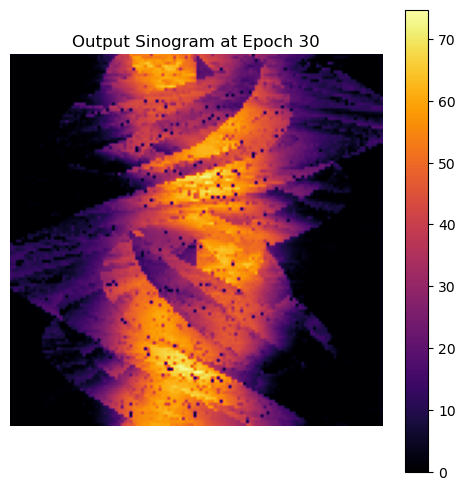

Epoch [31/150], Loss: 169.2776
Epoch [32/150], Loss: 162.0666
Epoch [33/150], Loss: 156.3753
Epoch [34/150], Loss: 150.0528
Epoch [35/150], Loss: 144.4409
Epoch [36/150], Loss: 138.6194
Epoch [37/150], Loss: 133.6957
Epoch [38/150], Loss: 130.1596
Epoch [39/150], Loss: 126.0184
Epoch [40/150], Loss: 120.3996


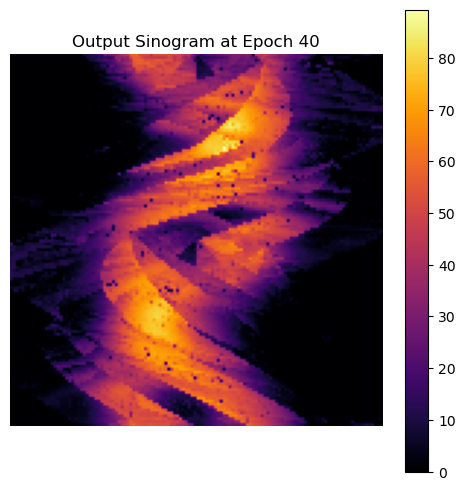

Epoch [41/150], Loss: 116.6103
Epoch [42/150], Loss: 112.3591
Epoch [43/150], Loss: 108.5178
Epoch [44/150], Loss: 105.0784
Epoch [45/150], Loss: 103.9551
Epoch [46/150], Loss: 98.9641
Epoch [47/150], Loss: 94.8510
Epoch [48/150], Loss: 92.5297
Epoch [49/150], Loss: 88.9548
Epoch [50/150], Loss: 86.0920


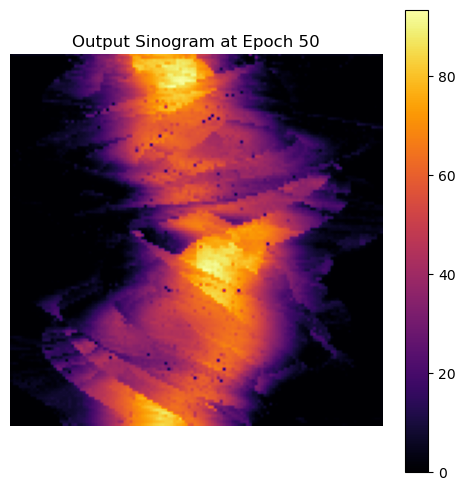

Epoch [51/150], Loss: 83.2251
Epoch [52/150], Loss: 80.4290
Epoch [53/150], Loss: 77.6557
Epoch [54/150], Loss: 75.5366
Epoch [55/150], Loss: 73.1885
Epoch [56/150], Loss: 71.4689
Epoch [57/150], Loss: 68.4210
Epoch [58/150], Loss: 66.1716
Epoch [59/150], Loss: 64.0539
Epoch [60/150], Loss: 62.2208


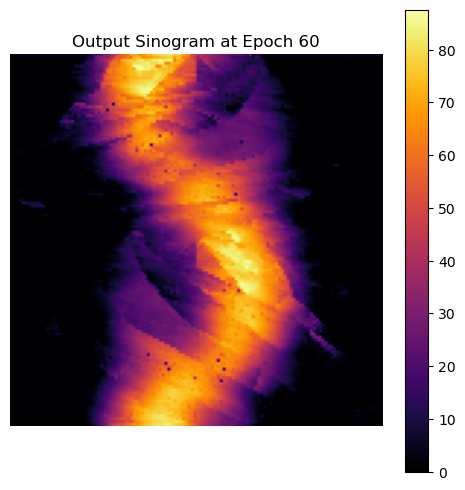

Epoch [61/150], Loss: 60.8604
Epoch [62/150], Loss: 58.7581
Epoch [63/150], Loss: 57.2570
Epoch [64/150], Loss: 56.5722
Epoch [65/150], Loss: 54.4354
Epoch [66/150], Loss: 52.8454
Epoch [67/150], Loss: 51.6730
Epoch [68/150], Loss: 50.5831
Epoch [69/150], Loss: 49.5000
Epoch [70/150], Loss: 47.7305


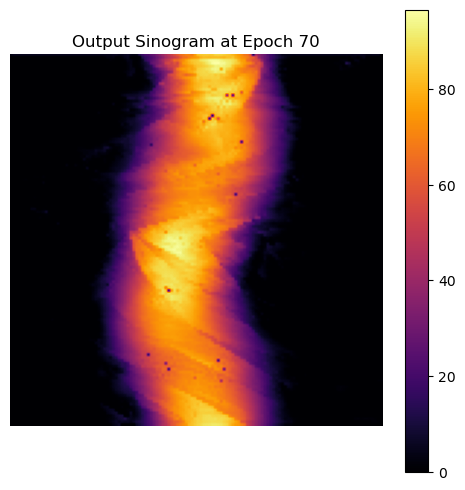

Epoch [71/150], Loss: 46.7361
Epoch [72/150], Loss: 45.5920
Epoch [73/150], Loss: 44.7494
Epoch [74/150], Loss: 44.1434
Epoch [75/150], Loss: 43.0746
Epoch [76/150], Loss: 41.9700
Epoch [77/150], Loss: 41.4833
Epoch [78/150], Loss: 40.2758
Epoch [79/150], Loss: 39.6376
Epoch [80/150], Loss: 38.5505


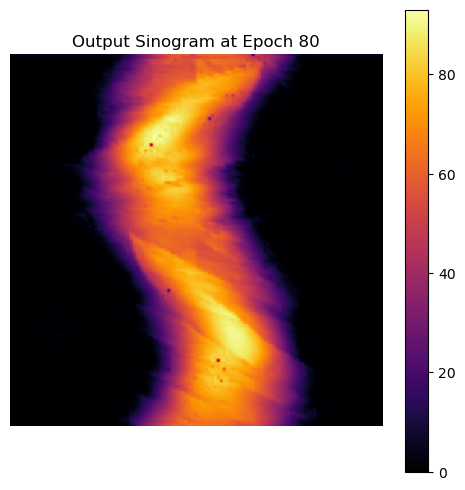

Epoch [81/150], Loss: 38.5252
Epoch [82/150], Loss: 37.1439
Epoch [83/150], Loss: 36.4460
Epoch [84/150], Loss: 35.9475
Epoch [85/150], Loss: 35.3831
Epoch [86/150], Loss: 35.3839
Epoch [87/150], Loss: 35.1243
Epoch [88/150], Loss: 33.8909
Epoch [89/150], Loss: 33.6021
Epoch [90/150], Loss: 34.2059


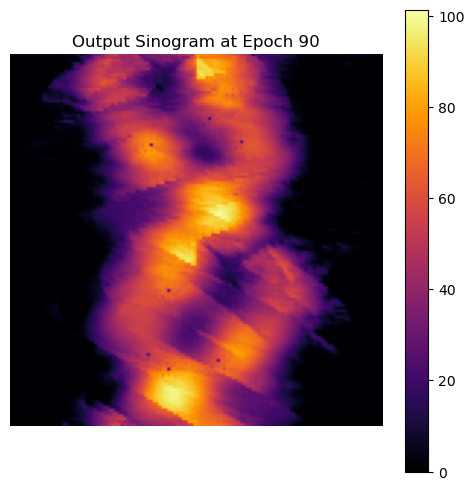

Epoch [91/150], Loss: 32.2811
Epoch [92/150], Loss: 32.7556
Epoch [93/150], Loss: 32.4292
Epoch [94/150], Loss: 30.7534
Epoch [95/150], Loss: 30.2238
Epoch [96/150], Loss: 30.4808
Epoch [97/150], Loss: 29.8076
Epoch [98/150], Loss: 29.0239
Epoch [99/150], Loss: 28.6464
Epoch [100/150], Loss: 28.5934


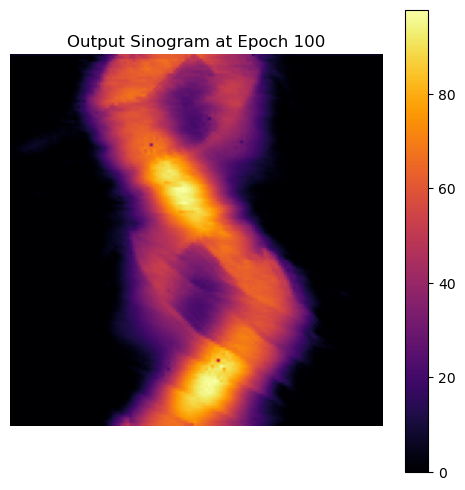

Epoch [101/150], Loss: 28.9283
Epoch [102/150], Loss: 28.4035
Epoch [103/150], Loss: 27.8603
Epoch [104/150], Loss: 28.7415
Epoch [105/150], Loss: 27.9321
Epoch [106/150], Loss: 26.8905
Epoch [107/150], Loss: 26.3005
Epoch [108/150], Loss: 26.1659
Epoch [109/150], Loss: 27.3509
Epoch [110/150], Loss: 26.2380


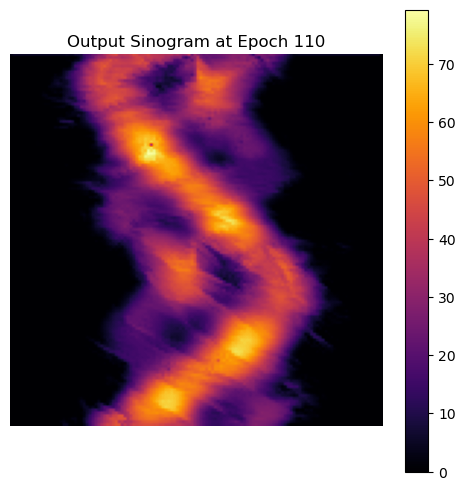

Epoch [111/150], Loss: 25.2900
Epoch [112/150], Loss: 25.0179
Epoch [113/150], Loss: 24.7134
Epoch [114/150], Loss: 24.6289
Epoch [115/150], Loss: 24.1981
Epoch [116/150], Loss: 23.9181
Epoch [117/150], Loss: 24.1838
Epoch [118/150], Loss: 23.5427
Epoch [119/150], Loss: 23.6430
Epoch [120/150], Loss: 23.3401


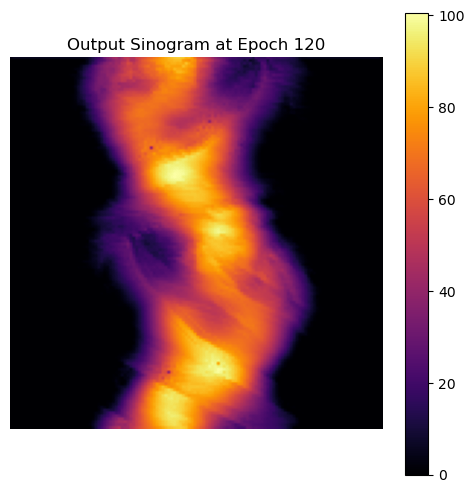

Epoch [121/150], Loss: 22.7309
Epoch [122/150], Loss: 22.7008
Epoch [123/150], Loss: 22.5132
Epoch [124/150], Loss: 22.6655
Epoch [125/150], Loss: 22.5876
Epoch [126/150], Loss: 21.9928
Epoch [127/150], Loss: 22.4426
Epoch [128/150], Loss: 22.2653
Epoch [129/150], Loss: 21.7397
Epoch [130/150], Loss: 21.7596


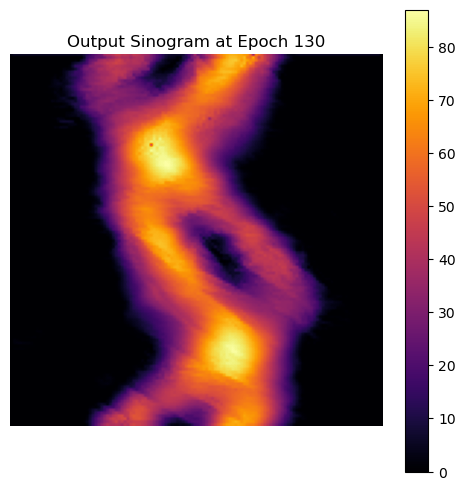

Epoch [131/150], Loss: 21.5656
Epoch [132/150], Loss: 20.9771
Epoch [133/150], Loss: 20.9762
Epoch [134/150], Loss: 20.9410
Epoch [135/150], Loss: 20.7997
Epoch [136/150], Loss: 20.6986
Epoch [137/150], Loss: 20.1623
Epoch [138/150], Loss: 20.0590
Epoch [139/150], Loss: 19.7581
Epoch [140/150], Loss: 19.6732


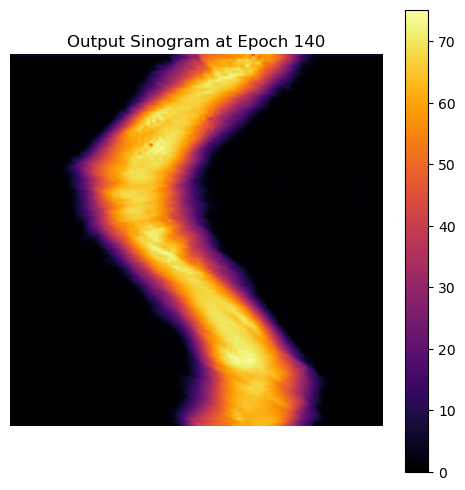

Epoch [141/150], Loss: 20.7836
Epoch [142/150], Loss: 20.6522
Epoch [143/150], Loss: 19.5304
Epoch [144/150], Loss: 18.8964
Epoch [145/150], Loss: 18.8598
Epoch [146/150], Loss: 18.9654
Epoch [147/150], Loss: 18.7113
Epoch [148/150], Loss: 18.6454
Epoch [149/150], Loss: 18.5092
Epoch [150/150], Loss: 19.0649


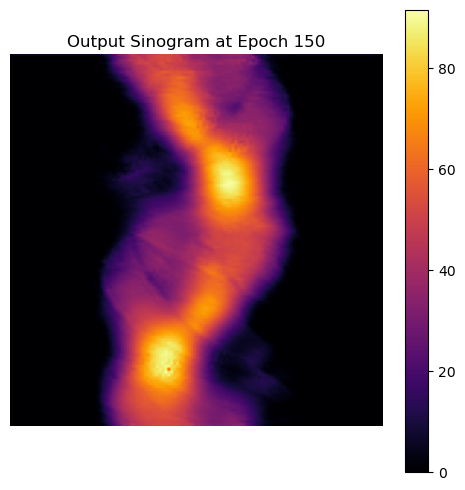

Training completed!


In [11]:
# ---------------------------
# Training Loop
# ---------------------------
num_epochs = training_config['num_epochs']
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (sino_noised, sino_clean) in enumerate(train_loader):
        sino_noised = sino_noised.to(device)
        sino_clean = sino_clean.to(device)
        
        optimizer.zero_grad()
        outputs = model(sino_noised)
        loss = mixed_loss(outputs, sino_clean, ssim_weight=training_config['ssim_weight'])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample_output = model(sino_noised)
        plt.figure(figsize=(6,6))
        plt.imshow(sample_output[0,0].detach().cpu().numpy(), cmap='inferno')
        plt.title(f"Output Sinogram at Epoch {epoch+1}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
        model.train()

print("Training completed!")

Epoch [201/150], Loss: 15.0388
Epoch [202/150], Loss: 14.6193
Epoch [203/150], Loss: 14.2586
Epoch [204/150], Loss: 15.3713
Epoch [205/150], Loss: 14.5493
Epoch [206/150], Loss: 14.3367
Epoch [207/150], Loss: 14.2910
Epoch [208/150], Loss: 14.1085
Epoch [209/150], Loss: 14.0546
Epoch [210/150], Loss: 14.1648


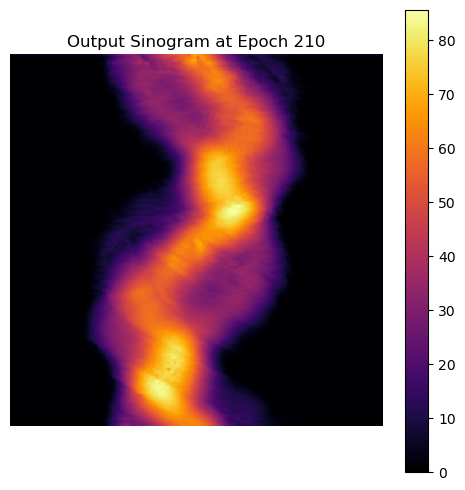

Epoch [211/150], Loss: 14.5788
Epoch [212/150], Loss: 13.9136
Epoch [213/150], Loss: 13.9241
Epoch [214/150], Loss: 13.9587
Epoch [215/150], Loss: 13.9970
Epoch [216/150], Loss: 14.1218
Epoch [217/150], Loss: 13.9605
Epoch [218/150], Loss: 13.9955
Epoch [219/150], Loss: 13.8705
Epoch [220/150], Loss: 14.2496


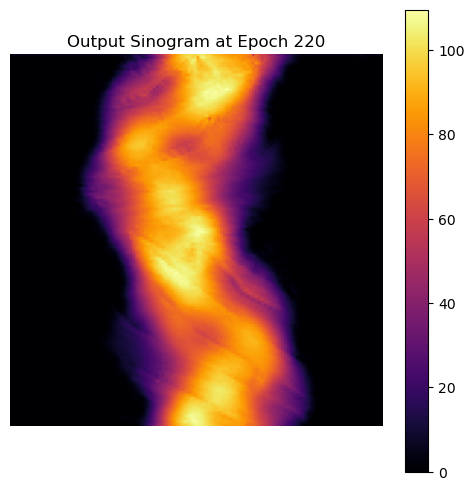

Epoch [221/150], Loss: 13.9720
Epoch [222/150], Loss: 13.3336
Epoch [223/150], Loss: 13.8720
Epoch [224/150], Loss: 13.7963
Epoch [225/150], Loss: 14.3959
Epoch [226/150], Loss: 13.9173
Epoch [227/150], Loss: 13.4419
Epoch [228/150], Loss: 13.2214
Epoch [229/150], Loss: 13.3056
Epoch [230/150], Loss: 13.6675


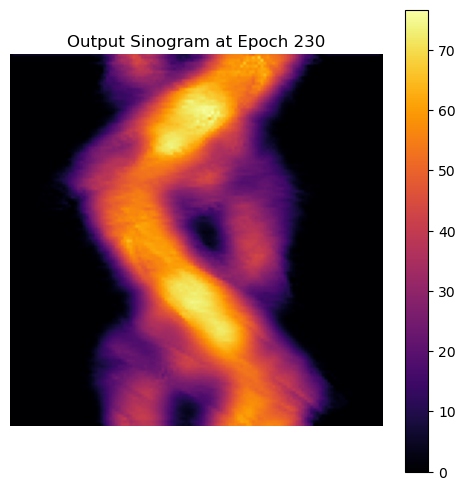

Epoch [231/150], Loss: 15.3853
Epoch [232/150], Loss: 13.2205
Epoch [233/150], Loss: 13.0989
Epoch [234/150], Loss: 12.8643
Epoch [235/150], Loss: 12.7140
Epoch [236/150], Loss: 12.7804
Epoch [237/150], Loss: 12.7073
Epoch [238/150], Loss: 12.6827
Epoch [239/150], Loss: 12.7060
Epoch [240/150], Loss: 12.8579


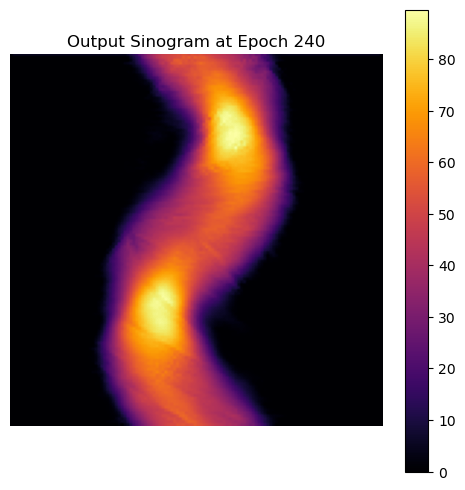

Epoch [241/150], Loss: 12.8854
Epoch [242/150], Loss: 12.7531
Epoch [243/150], Loss: 12.5349
Epoch [244/150], Loss: 12.6524
Epoch [245/150], Loss: 14.3969
Epoch [246/150], Loss: 12.9602
Epoch [247/150], Loss: 12.3239
Epoch [248/150], Loss: 12.2592
Epoch [249/150], Loss: 11.9914
Epoch [250/150], Loss: 12.0884


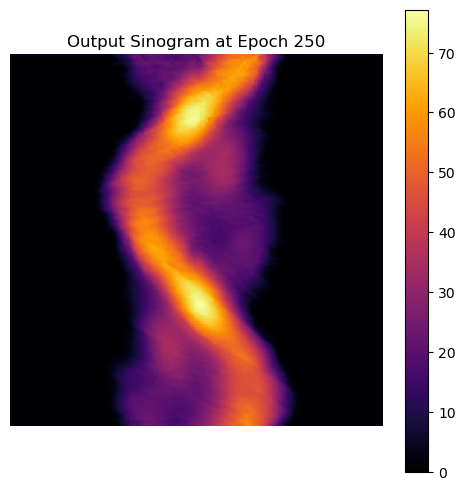

Epoch [251/150], Loss: 11.9973
Epoch [252/150], Loss: 12.0540
Epoch [253/150], Loss: 12.0409
Epoch [254/150], Loss: 12.0032
Epoch [255/150], Loss: 11.8316
Epoch [256/150], Loss: 12.0849
Epoch [257/150], Loss: 12.0135
Epoch [258/150], Loss: 11.9095
Epoch [259/150], Loss: 12.0734
Epoch [260/150], Loss: 11.9424


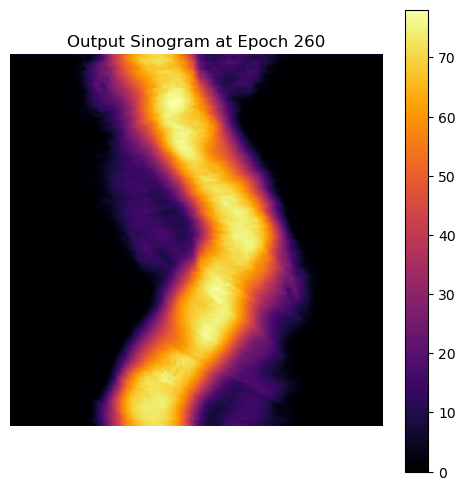

Epoch [261/150], Loss: 12.0008
Epoch [262/150], Loss: 11.7670
Epoch [263/150], Loss: 12.2986
Epoch [264/150], Loss: 12.0062
Epoch [265/150], Loss: 11.8120
Epoch [266/150], Loss: 11.5653
Epoch [267/150], Loss: 11.7337
Epoch [268/150], Loss: 11.4214
Epoch [269/150], Loss: 11.4877
Epoch [270/150], Loss: 11.2840


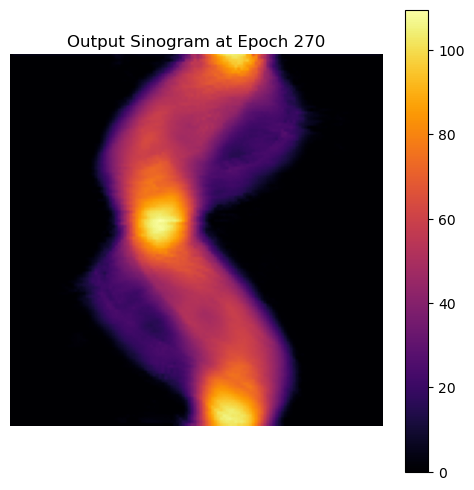

Epoch [271/150], Loss: 11.4967
Epoch [272/150], Loss: 12.3437
Epoch [273/150], Loss: 11.4642
Epoch [274/150], Loss: 11.2737
Epoch [275/150], Loss: 11.2896
Epoch [276/150], Loss: 11.2488
Epoch [277/150], Loss: 11.1454
Epoch [278/150], Loss: 11.1874
Epoch [279/150], Loss: 11.0804
Epoch [280/150], Loss: 10.9103


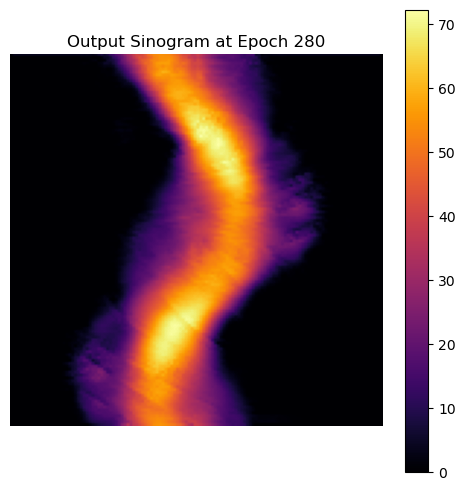

Epoch [281/150], Loss: 11.2547
Epoch [282/150], Loss: 11.4572
Epoch [283/150], Loss: 10.7661
Epoch [284/150], Loss: 10.8118
Epoch [285/150], Loss: 10.8391
Epoch [286/150], Loss: 10.8220
Epoch [287/150], Loss: 10.7645
Epoch [288/150], Loss: 10.6901
Epoch [289/150], Loss: 10.6696
Epoch [290/150], Loss: 10.6731


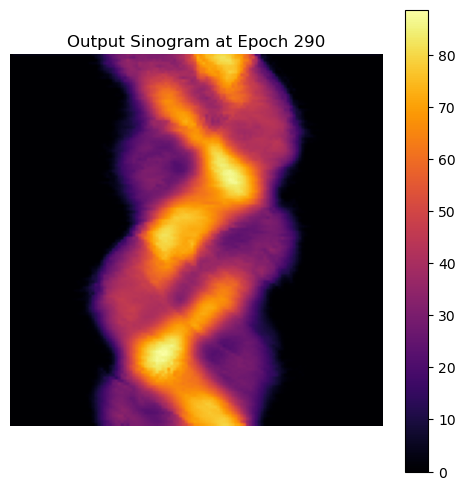

Epoch [291/150], Loss: 10.8504
Epoch [292/150], Loss: 10.8088
Epoch [293/150], Loss: 10.6361
Epoch [294/150], Loss: 10.6354
Epoch [295/150], Loss: 10.5611
Epoch [296/150], Loss: 10.7510
Epoch [297/150], Loss: 10.5321
Epoch [298/150], Loss: 10.4655
Epoch [299/150], Loss: 11.2017
Epoch [300/150], Loss: 10.8618


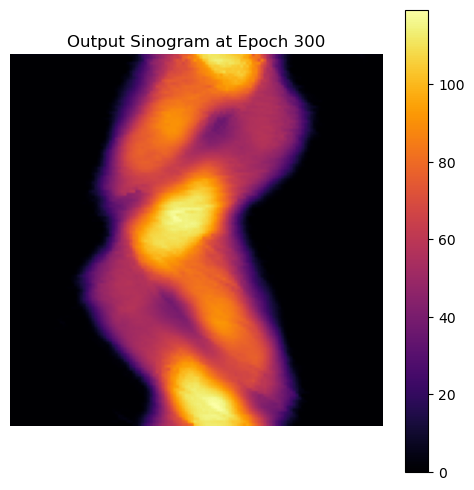

Training completed!


In [19]:
start_epoch = 200
total_epochs = 300
for epoch in range(start_epoch, total_epochs):
    running_loss = 0.0
    for batch_idx, (sino_noised, sino_clean) in enumerate(train_loader):
        sino_noised = sino_noised.to(device)
        sino_clean = sino_clean.to(device)
        
        optimizer.zero_grad()
        outputs = model(sino_noised)
        loss = mixed_loss(outputs, sino_clean, ssim_weight=training_config['ssim_weight'])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample_output = model(sino_noised)
        plt.figure(figsize=(6,6))
        plt.imshow(sample_output[0,0].detach().cpu().numpy(), cmap='inferno')
        plt.title(f"Output Sinogram at Epoch {epoch+1}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
        model.train()

print("Training completed!")

Validation PSNR: 30.17, SSIM: 0.8793


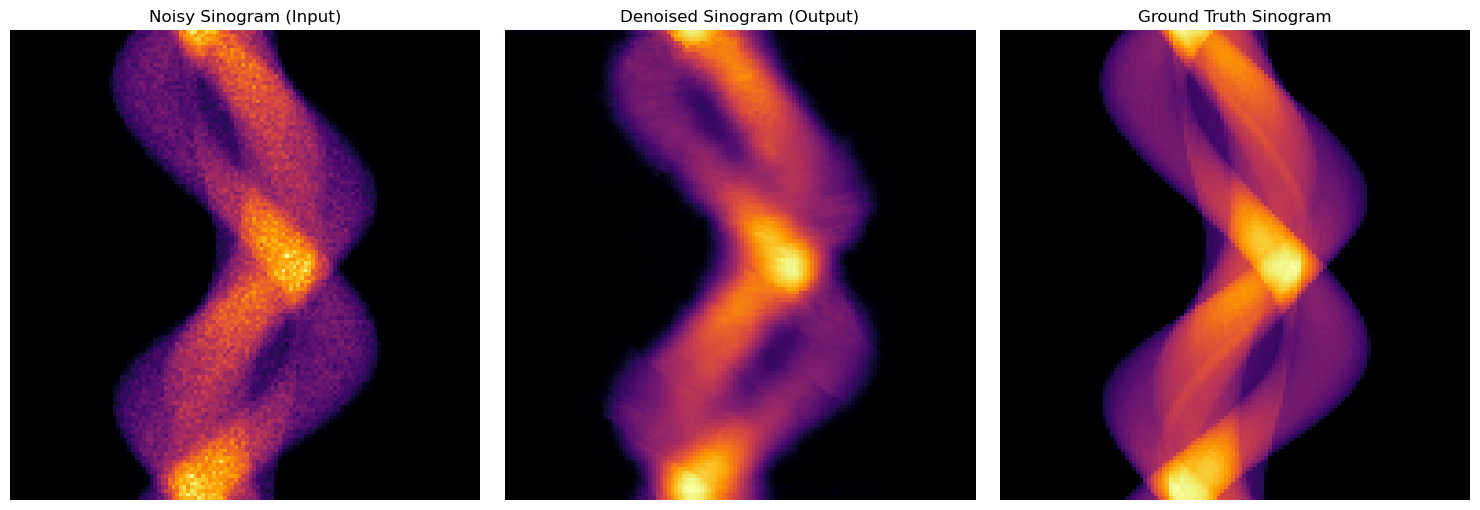

DualBranchTransformerModel(
  (sino_linear): Linear(in_features=3896, out_features=128, bias=True)
  (self_attn): Sequential(
    (0): SelfAttentionBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): SelfAttentionBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='

In [20]:
def validate(model, val_loader):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0
    with torch.no_grad():
        for sino_noised, sino_clean in val_loader:
            sino_noised = sino_noised.to(dev)
            sino_clean = sino_clean.to(dev)
            output = model(sino_noised)  # 只传入 sinogram
            # Compute metrics: PSNR and SSIM (假定 fom.psnr 和 fom.ssim 已经实现)
            for i in range(output.size(0)):
                out_np = output[i, 0].detach().cpu().numpy()
                target_np = sino_clean[i, 0].detach().cpu().numpy()
                psnr_val = fom.psnr(out_np, target_np)
                ssim_val = fom.ssim(out_np, target_np)
                total_psnr += psnr_val
                total_ssim += ssim_val
                count += 1
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
    model.train()
    return avg_psnr, avg_ssim

# 假设你已将数据集拆分为训练集和验证集，这里使用 PETCTTrainDataset
val_dataset = PETCTTrainDataset(dataset_dict)
val_loader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=False)

# 进行验证
avg_psnr, avg_ssim = validate(model, val_loader)
print(f"Validation PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

# 可视化验证集中的一个样本
model.eval()
with torch.no_grad():
    # 取验证集中的第一个样本
    sample_noised, sample_clean = val_dataset[0]
    # 增加 batch 维度：[1, 1, 128, 128]
    sample_noised = sample_noised.unsqueeze(0).to(dev)
    sample_clean = sample_clean.unsqueeze(0).to(dev)
    
    # 前向传播得到网络输出
    sample_output = model(sample_noised)

# 转换为 numpy 数组并移除 batch 与 channel 维度
noisy_np  = sample_noised[0, 0].detach().cpu().numpy()
output_np = sample_output[0, 0].detach().cpu().numpy()
gt_np     = sample_clean[0, 0].detach().cpu().numpy()

# 三图并排显示
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(noisy_np, cmap='inferno')
axs[0].set_title("Noisy Sinogram (Input)")
axs[0].axis('off')
axs[1].imshow(output_np, cmap='inferno')
axs[1].set_title("Denoised Sinogram (Output)")
axs[1].axis('off')
axs[2].imshow(gt_np, cmap='inferno')
axs[2].set_title("Ground Truth Sinogram")
axs[2].axis('off')
plt.tight_layout()
plt.show()

model.train()

In [21]:
# save checkpoint
checkpoint_path = "model_ViT_latest.pth"
torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

Model checkpoint saved to model_ViT_latest.pth


In [ ]:
# ---------------------------
#  a kind of code style
# ---------------------------
class DualBranchTransformerModel(nn.Module):
    def __init__(self, indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(DualBranchTransformerModel, self).__init__()
        self.indices = indices  # [num_patches, patch_length, 4]
        self.num_patches = indices.shape[0]
        self.max_length = indices.shape[1]
        
        # Sinogram token embedding: 将每个 patch 提取的 token（长度为 max_length）映射到 embedding 空间
        self.sino_linear = nn.Linear(self.max_length, embed_dim)
        
        # Positional encodings (一份，每个 patch 一个编码)
        self.positional_encodings = nn.Parameter(torch.randn(self.num_patches * 1, embed_dim))
        
        # Global self-attention layers (采用两层 Transformer)
        self.layers = nn.Sequential(Transformer(), Transformer())
        
        # Tail block: 将 embedding 映射回 token 原始长度
        self.tail = nn.Sequential(
            nn.Linear(embed_dim, self.max_length),
            nn.ReLU()
        )
        
        # Residual block for local enhancement
        self.residualBlock = nn.Sequential(
            Rearrange('b c h w s -> (b s) c h w'),
            ResidualBlock(in_channels=1, out_channels=1),
            Rearrange('(b s) c h w -> b c h w s', s=1)
        )
    
    def forward(self, sino):
        # sino: [B, 1, H, W]
        B = sino.shape[0]
        # --- Token extraction ---
        # 对于每个预先计算的 patch（由 get_indices 得到索引），逐个提取 sinogram 中对应的像素构成 token
        token_list = []
        for p in range(self.num_patches):
            idx = self.indices[p]  # [patch_length, 4]
            rows = idx[:, 2].to(sino.device)
            cols = idx[:, 3].to(sino.device)
            patch_tokens = []
            for b in range(B):
                patch_tokens.append(sino[b, 0, rows, cols])  # 提取出该 patch 的 token，形状 [patch_length]
            patch_tokens = torch.stack(patch_tokens, dim=0)  # [B, patch_length]
            token_list.append(patch_tokens)
        # tokens: [B, num_patches, patch_length]
        tokens = torch.stack(token_list, dim=1)
        
        # Linear mapping to embedding space
        H_enc = self.sino_linear(tokens)  # [B, num_patches, embed_dim]
        
        # Add positional encodings: 这里直接用随机初始化的编码，并重复到 batch 维度
        positional = self.positional_encodings.repeat(B, 1, 1)  # [B, num_patches, embed_dim]
        Z = H_enc + positional
        
        # Global self-attention layers (Transformer)
        Z = self.layers(Z)  # [B, num_patches, embed_dim]
        
        # Decode embeddings back to token length
        decoded_tokens = self.tail(Z)  # [B, num_patches, max_length]
        
        # Write decoded tokens back into sinogram
        sino_clone = sino.clone().squeeze(1)  # [B, H, W]
        for b in range(B):
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2].to(sino.device)
                cols = idx[:, 3].to(sino.device)
                sino_clone[b, rows, cols] = decoded_tokens[b, p]
        
        # Apply residual block for local enhancement
        sino_out = self.residualBlock(sino_clone.unsqueeze(1).unsqueeze(-1))  # [B, 1, H, W, 1]
        return sino_out.squeeze(-1)

In [ ]:
class SelfAttentionBlock(nn.Module):
    """
    一个简单的自注意力层：
    - Q, K, V 全来自 sinogram tokens
    - 之后加残差和 MLP
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(SelfAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x: [B, num_patches, embed_dim]，自注意力 -> (Q=K=V=x)
        attn_output, attn_weights = self.mha(
            query=x,
            key=x,
            value=x
        )
        # 残差 + LayerNorm
        x = self.norm1(x + attn_output)
        # MLP
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x, attn_weights

class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention layer:
    - Query comes from sinogram tokens
    - Key, Value come from kernel tokens
    - Then perform residual connection and MLP
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(CrossAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.GELU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, sinogram_tokens, kernel_tokens):
        # sinogram_tokens: [B, num_patches, embed_dim] (Query)
        # kernel_tokens:   [B, num_patches, embed_dim] (Key, Value)
        # MultiheadAttention requires (N, S, E), when batch_first=True it is (N, B, E)
        attn_output, attn_weights = self.mha(
            query=sinogram_tokens,
            key=kernel_tokens,
            value=kernel_tokens
        )
        # Residual connection + LayerNorm
        x = self.norm1(sinogram_tokens + attn_output)
        # MLP
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x, attn_weights

# ---------------------------
# Model Definition: DualBranchTransformerModel
# ---------------------------
class DualBranchTransformerModel(nn.Module):
    def __init__(self, indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(DualBranchTransformerModel, self).__init__()
        self.indices = indices
        self.num_patches = indices.shape[0]
        self.max_length = indices.shape[1]
        
        # Sinogram token embedding
        self.sino_linear = nn.Linear(self.max_length, embed_dim)
        
        # Kernel token embedding
        self.kernel_patch_embed = nn.Conv2d(1, embed_dim, kernel_size=config['patch_size'], stride=config['patch_size'])
        self.kernel_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        nn.init.trunc_normal_(self.kernel_pos_embed, std=0.02)
        
        # Multiple cross-attention layers
        self.cross_attn_blocks = nn.ModuleList([
            CrossAttentionBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # Multiple self-attention layers (allow sinogram tokens to interact)
        self.self_attn_blocks = nn.ModuleList([
            SelfAttentionBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # Decoder
        self.sino_decoder = nn.Linear(embed_dim, self.max_length)
    
    def forward(self, sino, kernel):
        B = sino.shape[0]
        tokens = []
        for b in range(B):
            sino_b = sino[b, 0]  # [H_s, W_s]
            patch_tokens = []
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2]
                cols = idx[:, 3]
                patch_vals = sino_b[rows, cols]
                patch_tokens.append(patch_vals)
            patch_tokens = torch.stack(patch_tokens, dim=0)
            tokens.append(patch_tokens)
        # Shape: [B, num_patches, max_length]
        tokens = torch.stack(tokens, dim=0)
        
        # Sinogram tokens
        sino_tokens = self.sino_linear(tokens)  # [B, num_patches, embed_dim]
        
        # Kernel tokens
        kernel_emb = self.kernel_patch_embed(kernel)  # [B, embed_dim, 4,4]
        kernel_emb = kernel_emb.flatten(2).transpose(1,2)  # [B, num_patches, embed_dim]
        kernel_emb = kernel_emb + self.kernel_pos_embed
        
        # First apply multiple cross-attention layers (sino_tokens <-> kernel_tokens)
        for block in self.cross_attn_blocks:
            sino_tokens, attn_w = block(sino_tokens, kernel_emb)
        
        # Then apply multiple self-attention layers (sino_tokens interact among themselves)
        for block in self.self_attn_blocks:
            sino_tokens, attn_w2 = block(sino_tokens)
        
        # Decode
        decoded_tokens = self.sino_decoder(sino_tokens)  # [B, num_patches, max_length]
        
        # Write back
        sino_out = sino.clone()
        for b in range(B):
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2]
                cols = idx[:, 3]
                sino_out[b, 0, rows, cols] = decoded_tokens[b, p]
        return sino_out
